In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('Datasets/resampled_dataset.csv')

# Features and target
X = df.drop(columns=['goal'])  # Replace 'goal' with your actual target column
y = df['goal']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Initial LightGBM Parameters
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
}


In [13]:
# Train the model
print("Training LightGBM...")
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,  # Maximum boosting rounds
    valid_sets=[train_data, test_data],  # Validation data for early stopping
    valid_names=['train', 'valid'],  # Optional: name the datasets
)

# Predict on test set
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_binary = (y_pred > 0.5).astype(int)



Training LightGBM...
[LightGBM] [Info] Number of positive: 49581, number of negative: 49580
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2038
[LightGBM] [Info] Number of data points in the train set: 99161, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000020
[LightGBM] [Info] Start training from score 0.000020



Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     12396
           1       0.82      0.84      0.83     12395

    accuracy                           0.83     24791
   macro avg       0.83      0.83      0.83     24791
weighted avg       0.83      0.83      0.83     24791


Confusion Matrix:
[[10166  2230]
 [ 1999 10396]]

AUC-ROC Score: 0.9163947829727114


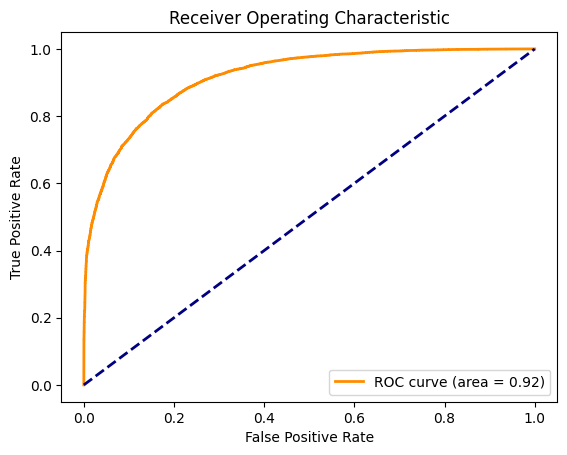


Feature Importance:
                Feature  Importance
6              gk_pos_x        4673
7              gk_pos_y        4602
0                     x        4098
4  defenders_position_x        3791
5  defenders_position_y        3698
1                     y        3688
2              distance        2883
3                 angle        2567


In [14]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(cm)

# AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred)
print("\nAUC-ROC Score:", roc_auc)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature importance
importance = gbm.feature_importance()
feature_names = X.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Save the feature importance to a CSV file if needed
feature_importance.to_csv('feature_importance.csv', index=False)


In [24]:
new_shot = pd.DataFrame({
    'x': [70],                # Example x-coordinate
    'y': [37.5],                # Example y-coordinate
    'distance': [6.041522986797286],         # Distance from goal
    'angle': [1.1347914444368148],            # Angle of the shot
    'defenders_position_x': [110.81428571428572], # Defenders' position (x)
    'defenders_position_y': [36.92857142857143],  # Defenders' position (y)
    'gk_pos_x': [109.4],          # Goalkeeper position (x)
    'gk_pos_y': [42.9],          # Goalkeeper position (y)
})
#114.5,37.5,6.041522986797286,1.1347914444368148,110.81428571428572,36.92857142857143,109.4,42.9

# Predicting with the trained model
y_pred_new = gbm.predict(new_shot)

# Convert the predicted probability to a binary result (0 or 1)
y_pred_new_binary = (y_pred_new > 0.5).astype(int)
print(y_pred_new_binary)

if y_pred_new_binary[0] >= 0.5:
    print("The shot will be a goal!")
else:
    print("The shot will miss.")

[0]
The shot will miss.
